## Imports

In [123]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
import bokeh
bokeh.io.output_notebook()
az.style.use(["arviz-colors"])
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.titlesize"] = 15

import scipy.stats as stats
import pymc3 as pm

Loading BokehJS ...

## Chain diagnostics

In [59]:
good_chains = stats.beta(2, 5).rvs(size=(2,2000))
bad_chains_0 = np.random.normal(np.sort(good_chains, axis=None), 0.05).reshape(2, -1)
bad_chains_1 = good_chains.copy()
for i in range(bad_chains_1.shape[0]):
    for idx in np.random.randint(0, 1800, size=3):
        bad_chains_1[i, idx: idx+200] = np.random.beta(idx, 1000, size=200)

In [60]:
chains = {"good_chains": good_chains,
          "bad_chains_0": bad_chains_0, 
          "bad_chains_1": bad_chains_1}

### Effective sample size

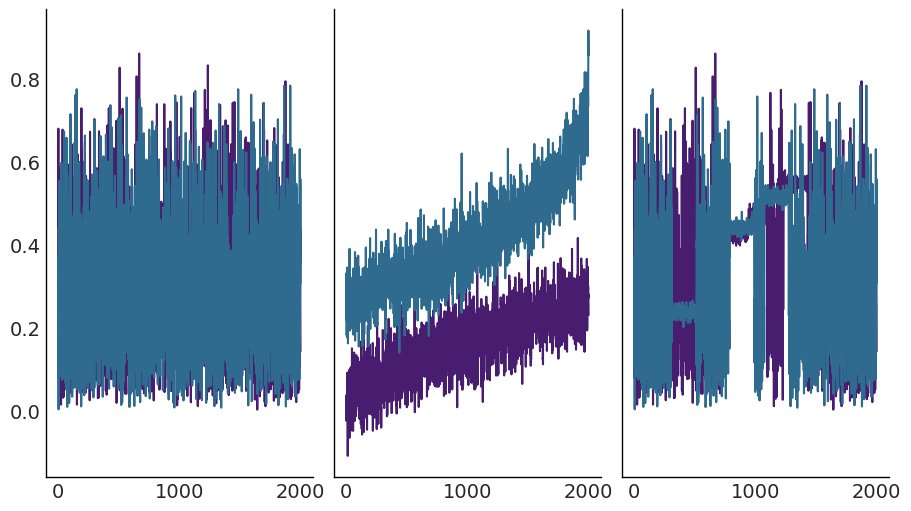

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(9, 5), sharey=True)
t = np.arange(2000)
for i, (k, v) in enumerate(chains.items()):
    axes[i].plot(t,
                 v.T,
                 "-",
                )

In [67]:
az.ess(chains)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 4.029e+03
    bad_chains_0  float64 2.456
    bad_chains_1  float64 94.63

C:\Users\andri\AppData\Local\Temp\ipykernel_18344\955772292.py:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


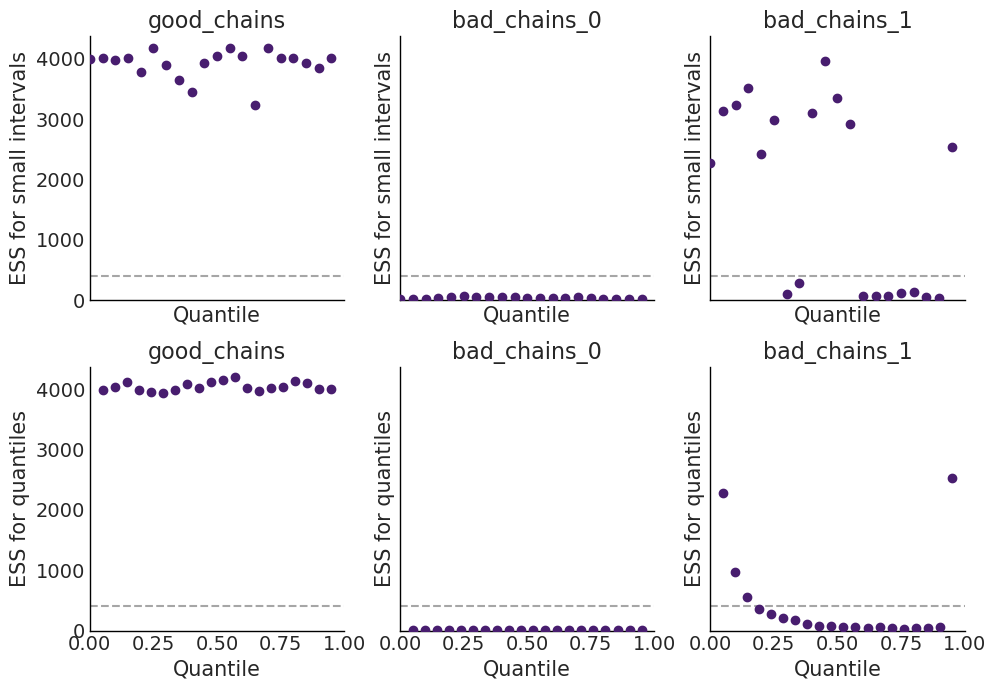

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])
plt.tight_layout()

### $\hat{R}$ parameter

In [69]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 1.0
    bad_chains_0  float64 2.363
    bad_chains_1  float64 1.014

### Monte Carlo Standard Error

In [70]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:       ()
Data variables:
    good_chains   float64 0.002499
    bad_chains_0  float64 0.1077
    bad_chains_1  float64 0.01801

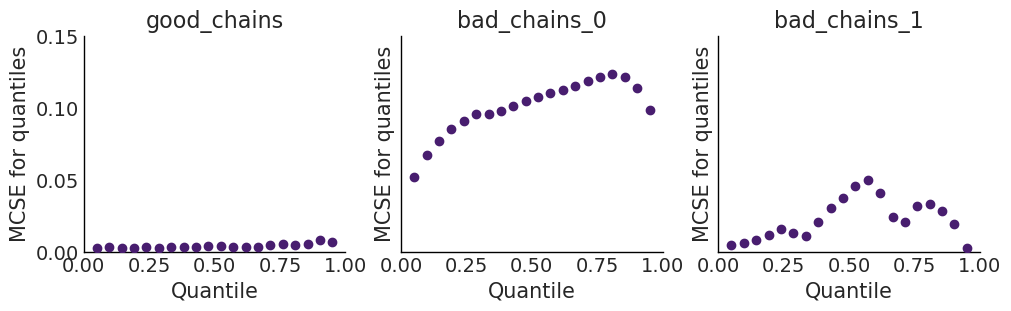

In [71]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
for ax_ in ax[1:]:
    ax_.set_ylabel("")
ax_.set_ylim(0, 0.15)
az.plot_mcse(chains, ax=ax);


### Combine all diagnostics

In [72]:
az.summary(chains, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.002,0.002,4029.0,3988.0,1.00
bad_chains_0,0.108,0.088,2.0,11.0,2.36
bad_chains_1,0.018,0.013,95.0,2275.0,1.01


`mcse_mean` is the standard error of the mean as can be seen below

In [73]:
print(f"Standard error for the mean - good chains: {chains['good_chains'].std()/np.sqrt(3866)}")
print(f"Standard error for the mean - good chains: {chains['bad_chains_0'].std()/np.sqrt(2)}")
print(f"Standard error for the mean - good chains: {chains['bad_chains_1'].std()/np.sqrt(95)}")

Standard error for the mean - good chains: 0.0025677344286311704
Standard error for the mean - good chains: 0.11812296927151332
Standard error for the mean - good chains: 0.01658110864166453


`mcse_sd` is the standard error on the standard deviation

### Trace plots

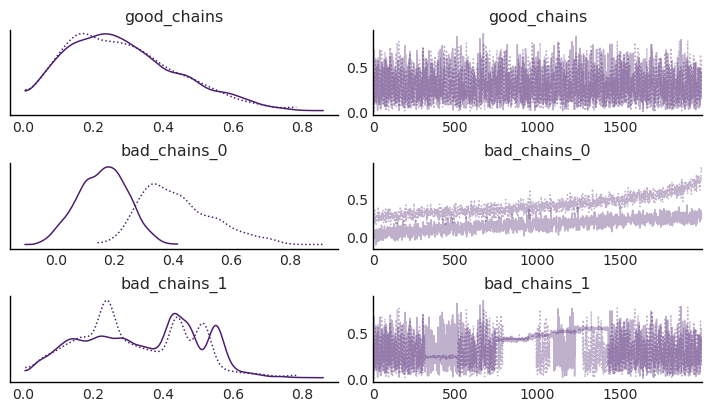

In [81]:
az.plot_trace(chains, figsize=(7, 4));

### Autocorrelation plots

In [97]:
# We also show that we can use the bokeh backend
az.plot_autocorr(chains, figsize=(12, 5), combined=True, textsize=11, backend="bokeh");

### Rank plots

Essentially we combine all the chains and rank all the values in them. In this specific example each value is assigned a rank between 1 and 4000. Then we split the chains again and bin the rank values. If all the chains have mixed well and have targeted the same distribution we expect that they have roughly the same amount of samples in each bin across a chain and between chains.

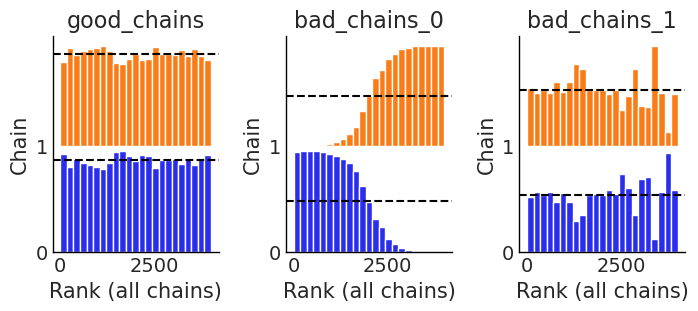

In [106]:
az.plot_rank(chains, kind="bars", figsize=(7, 3));

If we use vertical lines instead of histogram we get a represenation of "lack of samples" if the lines are below the dashed line and "excess of samples" if they are above.

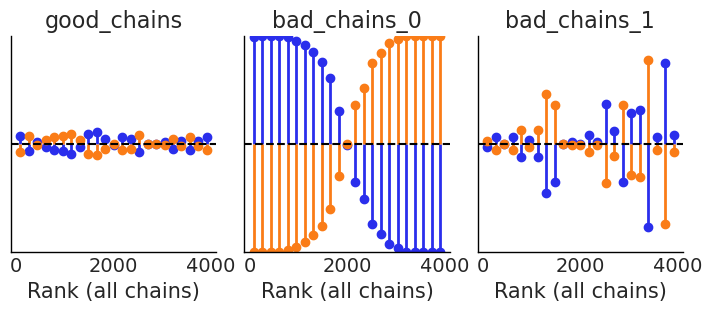

In [107]:
az.plot_rank(chains, kind="vlines", figsize=(7, 3));

We can also combine the rank plot in the trace plot style. Rank plots are more sensitive to possible problems.

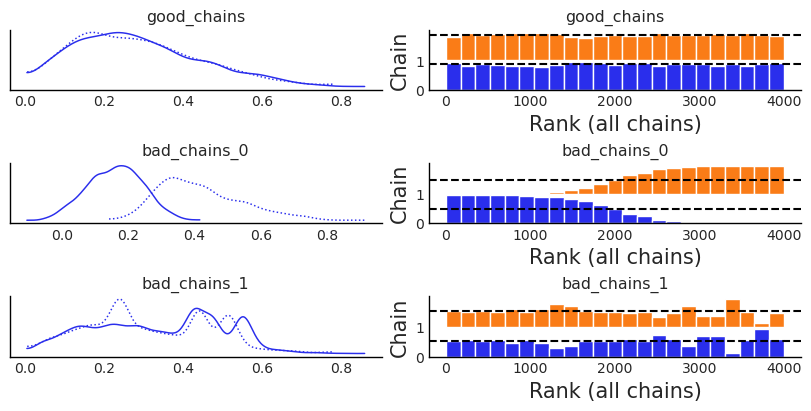

In [116]:
az.plot_trace(chains, kind="rank_bars", figsize=(8, 4));

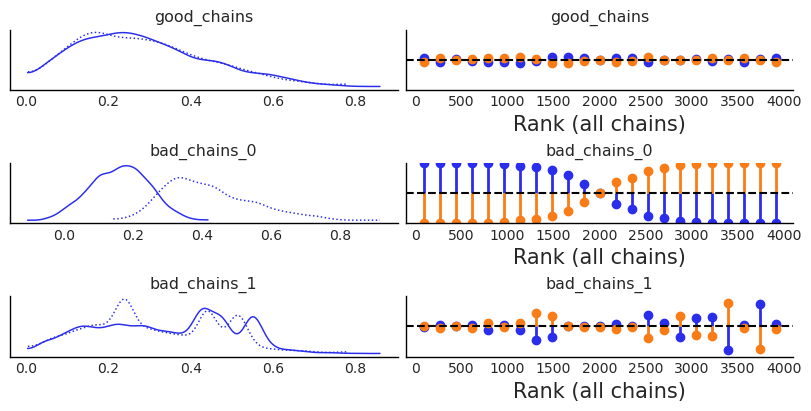

In [117]:
az.plot_trace(chains, kind="rank_vlines", figsize=(8, 4));

### Divergences

In [118]:
with pm.Model() as model_20:
    theta1 = pm.Normal("theta1", 0, 1, testval=0.1)
    theta2 = pm.Uniform("theta2", -theta1, theta1)
    idata_0 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 579 divergences after tuning. Increase `target_accept` or reparameterize.
There were 667 divergences after tuning. Increase `target_accept` or reparameterize.
There were 608 divergences after tuning. Increase `target_accept` or reparameterize.
There were 577 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


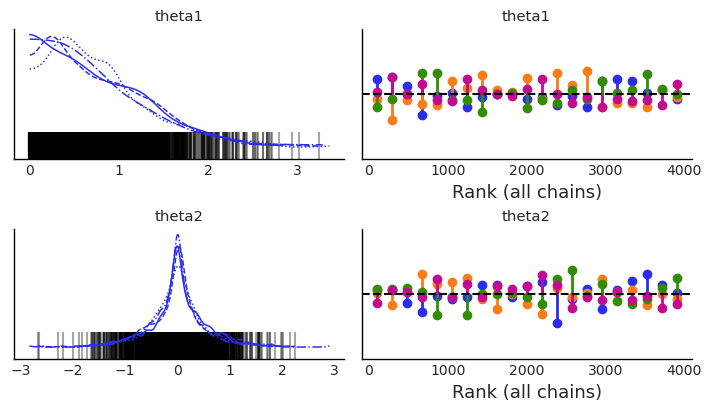

In [124]:
az.plot_trace(idata_0, kind="rank_vlines", figsize=(7, 4));

<AxesSubplot:xlabel='theta1', ylabel='theta2'>

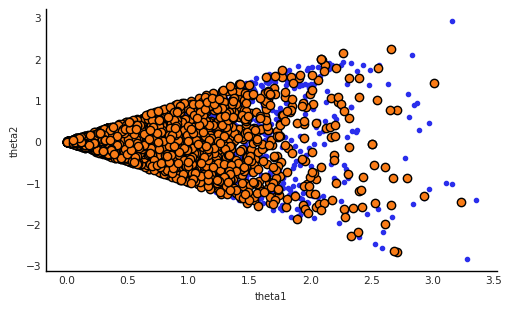

In [131]:
# With pair plots
az.plot_pair(idata_0, divergences=True, figsize=(5, 3))

In [132]:
with pm.Model() as model_21:
    theta1 = pm.HalfNormal("theta1", 1)
    theta2 = pm.Uniform("theta2", -theta1, theta1)
    idata_1 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [133]:
with pm.Model() as model_22:
    theta1 = pm.HalfNormal("theta1", 1)
    theta2 = pm.Uniform("theta2", -theta1, theta1)
    idata_2 = pm.sample(return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


## Model comparison

In [134]:
y_obs = np.random.normal(0, 1, 100)
idatas = {}

### Pareto Smoothed importance sampling leave-one-out cross validation

In [136]:
with pm.Model() as model_23:
    sigma = pm.HalfNormal("sigma", 
                          sd=1
                         )
    y = pm.SkewNormal("y",
                      mu=0,
                      sd=sigma,
                      alpha=1,
                      observed=y_obs
                     )
    idata_1 = pm.sample(return_inferencedata=True)
    
    idata_1.add_groups({
        "posterior_predictive": {
            "y":pm.sample_posterior_predictive(idata_1, var_names=["y"])["y"][None, :]
        }
    })
    
idatas["m1"] = idata_1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [144]:
with pm.Model() as model_24:
    σ = pm.HalfNormal("σ", 
                      sd=1
                     )
    y = pm.Normal("y",
                  mu=0, 
                  sd=σ,
                  observed=y_obs
                 )
    idata_2 = pm.sample(return_inferencedata=True)
    idata_2.add_groups({
        "posterior_predictive": {
            "y": pm.sample_posterior_predictive(idata_2, var_names=["y"])["y"][None, :]
        }
    })
idatas["m2"] = idata_2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [145]:
with pm.Model() as model_25:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y",
                  mu=μ,
                  sigma=σ,
                  observed=y_obs
                 )
    idata_3 = pm.sample(return_inferencedata=True)
    idata_3.add_groups({
        "posterior_predictive": {
            "y": pm.sample_posterior_predictive(idata_3, var_names=["y"])["y"][None, :]
        }
    })
idatas["m3"] = idata_3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


To calculate psis-loo-cv for one model:

#### Global comparison

In [147]:
az.loo(idatas["m1"])

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -149.10     8.74
p_loo        0.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

To compare multiple models:

In [148]:
az.compare(idatas)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3,0,-136.153595,1.824035,0.000000,7.437973e-16,6.646934,0.000000,False,log
m2,1,-136.484390,0.834799,0.330795,7.718030e-01,6.711037,1.601234,False,log
m1,2,-149.096293,0.974801,12.942698,2.281970e-01,8.744108,5.474834,False,log


<AxesSubplot:xlabel='Log'>

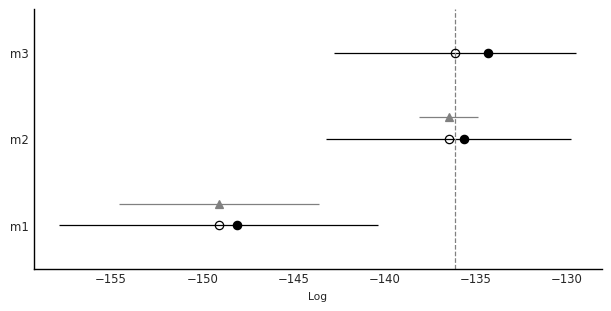

In [151]:
az.plot_compare(az.compare(idatas))

#### Local comparison

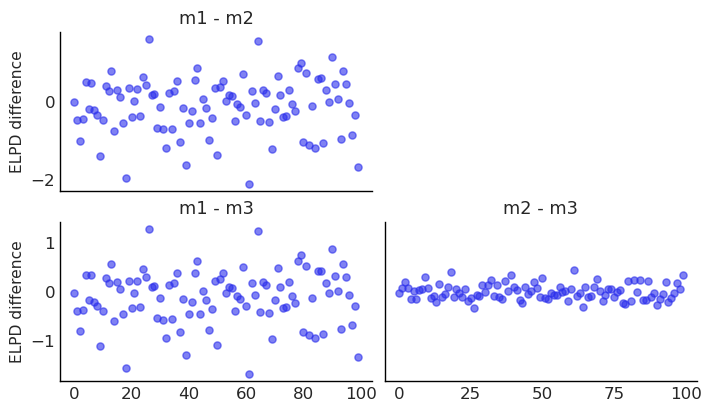

In [158]:
az.plot_elpd(idatas,
             color="C0",
             plot_kwargs={"alpha": 0.6},
             figsize=(7, 4),
             textsize=12          
            );

### Pareto shape parameter

Helpful to identify observations that have a large effect on the posterior distribution. Large values of $\hat{\kappa}$ (>0.7) can indicate problems with the model or the data.

(-0.2, 0.25)

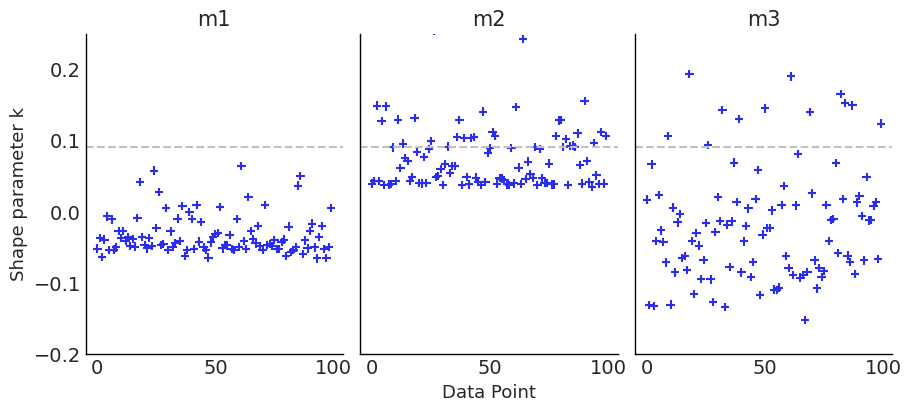

In [164]:
fig, axes = plt.subplots(1, len(idatas), figsize=(9, 4), sharey=True)
for i, model in enumerate(idatas.keys()):
    loo_ = az.loo(idatas[model], pointwise=True)
    az.plot_khat(loo_, legend=True, ax=axes[i])
    axes[i].axhline(y=0.09, linestyle="--", c="silver")
    axes[i].set_title(model)
    if i:  # checks if index != 0
        axes[i].set_ylabel("")
    if i != 1:
        axes[i].set_xlabel("")
axes[i].set_ylim(-0.2, 0.25)

One thing that can be done if there are many instances with large values of the shape parameters is to define the model in a way that it is more resilient to outliers. We can try to test this using a different data generation process and one more model.

### Models for heavier tails

In [166]:
y_obs = stats.cauchy(loc=0, scale=2).rvs(100)
idatas_cauchy = {}

In [169]:
with pm.Model() as model_26:
    σ = pm.HalfNormal("σ", 
                      sd=1
                     )
    y = pm.Normal("y",
                  mu=0, 
                  sd=σ,
                  observed=y_obs
                 )
    idata_4 = pm.sample(return_inferencedata=True)
    idata_4.add_groups({
        "posterior_predictive": {
            "y": pm.sample_posterior_predictive(idata_4, var_names=["y"])["y"][None, :]
        }
    })
idatas_cauchy["m1"] = idata_4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [170]:
with pm.Model() as model_27:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Normal("y",
                  mu=μ,
                  sigma=σ,
                  observed=y_obs
                 )
    idata_5 = pm.sample(return_inferencedata=True)
    idata_5.add_groups({
        "posterior_predictive": {
            "y": pm.sample_posterior_predictive(idata_5, var_names=["y"])["y"][None, :]
        }
    })
idatas_cauchy["m2"] = idata_5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8830317033249476, but should be close to 0.8. Try to increase the number of tuning steps.


In [171]:
with pm.Model() as model_28:
    μ = pm.Normal("μ", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    y = pm.Cauchy("y",
                  alpha=μ,
                  beta=σ,
                  observed=y_obs
                 )
    idata_6 = pm.sample(return_inferencedata=True)
    idata_6.add_groups({
        "posterior_predictive": {
            "y": pm.sample_posterior_predictive(idata_6, var_names=["y"])["y"][None, :]
        }
    })
idatas_cauchy["m3"] = idata_6

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [174]:
az.compare(idatas_cauchy)

C:\Users\andri\anaconda3\envs\bmcp\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\andri\anaconda3\envs\bmcp\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3,0,-312.137536,1.943671,0.000000,0.889277,15.134607,0.000000,False,log
m2,1,-385.181327,14.225695,73.043791,0.000000,45.946549,39.318426,True,log
m1,2,-386.340755,14.687087,74.203218,0.110723,47.313492,40.665148,True,log


C:\Users\andri\anaconda3\envs\bmcp\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\andri\anaconda3\envs\bmcp\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


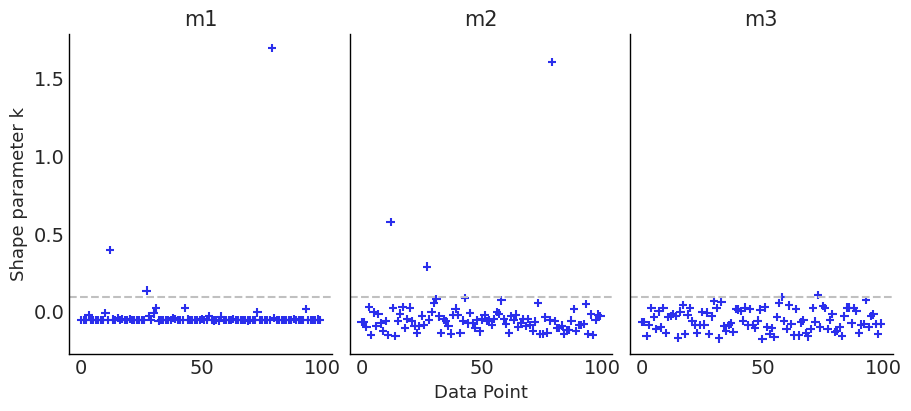

In [173]:
fig, axes = plt.subplots(1, len(idatas_cauchy), figsize=(9, 4), sharey=True)
for i, model in enumerate(idatas_cauchy.keys()):
    loo_ = az.loo(idatas_cauchy[model], pointwise=True)
    az.plot_khat(loo_, legend=True, ax=axes[i])
    axes[i].axhline(y=0.09, linestyle="--", c="silver")
    axes[i].set_title(model)
    if i:  # checks if index != 0
        axes[i].set_ylabel("")
    if i != 1:
        axes[i].set_xlabel("")

We see that the last model is the only one that is not affected by outliers.